Importy

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer, StandardScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import seaborn as sns

Ładowanie danych

In [2]:
data = pd.read_csv('t-shirts.csv')

# Eksploracja danych

In [3]:
data.shape

(20000, 5)

Dane zawierają 20000 rekordów i 5 kolumn.

In [4]:
data.head(20)

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium
5,XS,polyester,black,short,medium
6,XXL,polyester,green,short,medium
7,L,linen,yellow,short,high
8,XL,linen,cream,long,high
9,XS,nylon,red,short,high


Dane zawierają informacje o rozmiarze, materiale, kolorze, długości rękawów i zapotrzebowaniu koszulek. Każda kolumna zawiera dane tekstowe.

In [5]:
data.describe()

,size,material,color,sleeves,demand
count,20000,20000,20000,20000,20000
unique,7,5,10,2,3
top,L,nylon,white,long,high
freq,4408,5652,3286,10117,8965


Najwięcej unikalnych danych znajduje się w kolumnie color, a najmniej w sleeves. Poszczególne cechy posiadają dominujące kategorie, czyli takie które występują częściej od pozostałych. Jedyną kolumną, gdzie liczba rekordów poszczególnych kategorii jest do siebie zbliżona to sleeves. Ilość wystąpień najpopularniejszego typu w pozostałych atrybutach znacznie przekracza średnią.

In [6]:
data.groupby('demand').size()

demand
high      8965
low       2326
medium    8709
dtype: int64

W kolumnie demand kategorie high i medium mają zbliżoną ilość wystąpień, natomiast zdecydowanie odstaje low występujące od nich rzadziej o ponad 7000.

# Przygotowanie danych

In [7]:
data.isnull().sum()

size        0
material    0
color       0
sleeves     0
demand      0
dtype: int64

Nie znalezione zostały żadne braki w danych, w związku z czym pominięto krok uzupełniania danych.

In [8]:
data = pd.get_dummies(data, columns=['size', 'material', 'color', 'sleeves'])

Występowanie jedynie danych tekstowych w każdej z kolumn uniemożliwia wykorzystanie znacznej ilości funkcji służacych do przetworzenia danych oraz tworzących modele. Aby uniknąć tych problemów dane znajdujące się w kolumnach size, material, color i sleeves przekształcone zostały w osobne kolumny dla każdej występującej w nich kategorii zawierające 1 gdy wystąpuje i 0 w przeciwnym przypadku.

In [9]:
X_data, Y_data = data.drop(columns=['demand']), data['demand']

Dane podzielone zotały na kolumny, które służyć będą do przeprowadzenia przewidywania i na te które będą przewidywane (kolumna demand).

In [10]:
X_data

,size_3XL,size_L,size_M,size_S,size_XL,size_XS,size_XXL,material_cotton,material_linen,material_nylon,...,color_cream,color_green,color_navy,color_orange,color_red,color_violet,color_white,color_yellow,sleeves_long,sleeves_short
0,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
19996,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
19997,False,False,False,False,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True
19998,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False


Tabela przedstawiająca dane nieprzetworzone.

Metody zastosowane do przetworzenia danych to standaryzacja i PCA. Standaryzacja pozwoli nam na przekształcenie danych, tak aby miały one średnią równą 0 z odchyleniem standardowym 1. Natomiast PCA pozwoli przetworzyć dane, aby zwiększyć znaczenie kluczowych cech. Ponieważ dane zawierają jedynie 24 kolumny PCA nie zostanie wykorzystane, aby zredukować ich wymiarowość.

In [11]:
pca = PCA()
X_pca = pca.fit_transform(X_data)
X_pca

array([[-6.90252680e-01,  6.92781172e-01, -3.51360505e-01, ...,
         9.15623249e-15,  3.14995953e-15, -1.35589438e-17],
       [ 7.16641630e-01, -6.76710541e-01, -3.59400003e-01, ...,
         9.65663062e-15,  2.61845303e-15,  1.56733501e-16],
       [ 7.24875417e-01, -2.97294221e-02,  9.24611045e-02, ...,
         2.60896363e-16, -3.95233335e-15,  7.97038313e-16],
       ...,
       [ 7.07940733e-01, -9.80573715e-03,  8.09619860e-01, ...,
         7.93448387e-17, -1.54856873e-16,  4.18993212e-17],
       [-7.01879404e-01,  7.29475189e-01, -3.42748239e-01, ...,
         2.64881797e-16,  8.13251155e-18, -5.89156959e-17],
       [ 7.12666560e-01,  7.17348044e-01, -3.21971947e-01, ...,
         9.19379616e-17, -3.29225713e-17, -2.43559732e-17]])

Tabela przedstawiająca dane po przetworzeniu wykorzystującym PCA.

In [12]:
scaler = StandardScaler()
X_stand = scaler.fit_transform(X_data)
X_stand

array([[-0.30820516, -0.53170394, -0.4536918 , ..., -0.27445697,
         0.98836765, -0.98836765],
       [-0.30820516, -0.53170394, -0.4536918 , ..., -0.27445697,
        -1.01176925,  1.01176925],
       [-0.30820516, -0.53170394, -0.4536918 , ..., -0.27445697,
        -1.01176925,  1.01176925],
       ...,
       [-0.30820516, -0.53170394, -0.4536918 , ..., -0.27445697,
        -1.01176925,  1.01176925],
       [-0.30820516,  1.88074588, -0.4536918 , ..., -0.27445697,
         0.98836765, -0.98836765],
       [-0.30820516, -0.53170394, -0.4536918 , ..., -0.27445697,
        -1.01176925,  1.01176925]])

Tabela przedstawiająca dane po przetoworzeniu wykorzystującym standaryzację.

# Klasyfikacja

In [13]:
train_data = []
train_data.append(('unchanged', X_data))
train_data.append(('standarized', X_stand))
train_data.append(('pca', X_pca))

Lista wszystkich zbiorów danych.

In [14]:
models = []
models.append(('NB', GaussianNB()))
models.append(('DT_1', DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None
)))
models.append(('DT_2', DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_split=12,
    min_samples_leaf=6,
    max_features=None
)))
models.append(('DT_3', DecisionTreeClassifier(
    criterion='log_loss',
    max_depth=16,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features='sqrt',
)))

Lista wszystkich modeli przewidywujących

Model bazujący na naiwnym klasyfikatorze Bayesa (GaussianNB)
  

Model bazujący na drzewie decyzyjnym z domyślnymi parametrami (DT_1):
- Kryterium: gini, które koncentruje się na czystości podziału węzłów.
- Głębokość drzewa: nieograniczona.
- Minimalna liczba rekordów do podziału węzła: 2.
- Minimalna liczba rekordów w węźle liściowym: 1.
- Maksymalna liczba cech: brak ograniczeń (wszystkie cechy są brane pod uwagę).


Model bazujący na drzewie decyzyjnym z ograniczoną głębokością (DT_2):

- Kryterium: entropy, które koncentruje się na redukcji niepewności (entropii) przy każdym podziale.
- Głębokość drzewa: ograniczona do 8 poziomów, co pomaga w przeciwdziałaniu przeuczeniu (overfitting).
- Minimalna liczba rekordów do podziału węzła: 12.
- Minimalna liczba rekordów w węźle liściowym: 6.
- Maksymalna liczba cech: brak ograniczeń (wszystkie cechy są brane pod uwagę).


Model bazujący na drzewie decyzyjnym z ograniczoną liczbą rozpatrywanych cech (DT_3):

- Kryterium: log_loss (inaczej znane jako binarna entropia krzyżowa), które mierzy jakość podziału na podstawie logarytmicznej straty.
- Głębokość drzewa: ograniczona do 16 poziomów.
- Minimalna liczba rekordów do podziału węzła: 6.
- Minimalna liczba rekordów w węźle liściowym: 3.
- Maksymalna liczba cech: 'sqrt', co oznacza, że na każdym podziale rozważana jest tylko pierwiastek kwadratowy z liczby wszystkich cech.

In [15]:
scoring = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']

Lista zawierająca wszystkie metryki, które wykorzystane zostaną do oceny modeli.

In [16]:
results = []
names = []
for mname, model in models:
    for dname, X_train in train_data:
        
        result = {
            'model': mname,
            'data': dname,
        }
        
        for score in scoring:
            kfold = KFold(n_splits=5)
            cv_results = cross_val_score(model, X_train, Y_data, cv=kfold, scoring=score, error_score=1.0)
            
            result[score] = cv_results.mean()
            
        results.append(result)
        
    

Dla każdej konfiguracji modelu i zbioru danych następuje wytrenowanie modelu i jego ocena korzystając z walidacji krzyżowej. Wyniki rozumiane są jako średnia z 5 ocen testów wykonywanych podczas walidacji.

In [17]:
results_df = pd.DataFrame(results)
results_df

,model,data,accuracy,recall_macro,precision_macro,f1_macro
0,NB,unchanged,0.63205,0.603158,0.738723,0.596893
1,NB,standarized,0.63120,0.601989,0.748306,0.598690
2,NB,pca,0.70005,0.672322,0.650974,0.658110
3,DT_1,unchanged,0.95215,0.944709,0.941734,0.940138
4,DT_1,standarized,0.95215,0.944709,0.941734,0.940138
5,DT_1,pca,0.95220,0.944761,0.941425,0.939977
6,DT_2,unchanged,0.89515,0.866908,0.879744,0.868147
7,DT_2,standarized,0.89490,0.867365,0.879705,0.867831
8,DT_2,pca,0.94915,0.944464,0.937615,0.938727
9,DT_3,unchanged,0.93835,0.931147,0.931183,0.922715


Modele bazujące na drzewach decyzujnych wypadły zdecydowanie lepiej od naiwnego klasyfikatora Bayesa posiadając dokładność więkoszą o ponad 0.20. Pomimo najgorszego wyniku pierwszy model osiągnął dokładność w okolicach 0.63-0.7, co w niektórych obszarach, które nie wymagają sporej dokładności mogłoby zostać uznane jako częściowy sukces. Model zaliczył również znaczny wzrost (0.07 dokładności, czułości i f1), gdy trenowany był danymi po PCA. 
Drzewa osiągnęły wyniki na poziomie 0.89-0.95, co przekłada się na ich bardzo wysoką dokładność i można zdecydowanie uznać praktycznie każdy z nich za sukces. Najgorzej wypadło drzewo DT_2 korzytsające z danych ustandaryzowanych i niezmienionych. Najprawdopodobniej na słabszy performance tych modeli wpłynęły parametry tego drzewa ograniczające jego głębokość do 8 lub entropia jako kryterium oceny. Wartym zauważenia faktem jest to, że ponownie model, który trenowany był danymi po przetworzeniu PCA był znacznie dokładniejszy. Dokładność 5 najlepszych modeli wyniosła blisko 0.95 i są to: wszytskie 3 modele DT_1, DT_2 PCA oraz DT_3 PCA. DT_1 był drzewem posiadającym domyślne paramatery, więc jego przewaga nad pozostałymi modelami nie jest dużym zaskoczniem, ponieważ przeważnie standardowe ustawienia modelu są najbardziej uniwersalne dla wprowadzanych do niego danych. Dodatkowo nie posiadał on żadnego ograniczenia dotyczącego wielkości drzewa. Takie podejście pomimio możliwości wystąpienia overfittingu pozwala kosztem skomplikowania drzewa uzyskać przewagę nad ograniczonymi modelami. DT_3 pomimo ograniczenia rozważanych cech do ich pierwiastka tylko nieznacznie straciło na dokładności. Jak już wcześniej zostało wspomniane przetworzenie danych w każdnym modelu oprócz DT_1 wpłynęło bardzo pozytywnie na jego dokładność. Możliwe, że prztworzenie danych pozwoliło na zniwelowanie negatywnego wpływu ograniczenia głębokości drzewa. Standaryzacja danych nie miała lub miała znikomy wpływ na wynik modeli w poszczególnych miarach, co pradwopodobnie wynika z specyfiki danych treningowych, które były ograniczone jedynie do 0 lub 1 w każdej kolumnie.
Poszczególne miary działania modeli prezentują się inaczej dla drzew i NB. W przypadku danych nieprzetworzonych i ustandaryzowanych precyzja Bayesa jest znacznie wyższa (0.1 więcej) od pozostałych ocen. Klasyfikator bazujący na danych przetworzonych PCA natomiast posiada większą dokładność przy niższych innych metrykach. Modele wykorzystujące drzewa decyzyjne nie wykazują dużysz różnic w poszczególnych metrykach. Dla większości z nich minimalnie lepiej od reszty wypada dokładność. Różnice w rozkładzie wyników dla Bayesa i drzew decyzyjnych najprawdopodobniej wynikają z innego sposobu uwzględniania poszczególnych cech przy predykcji oraz ich sposobu działania.

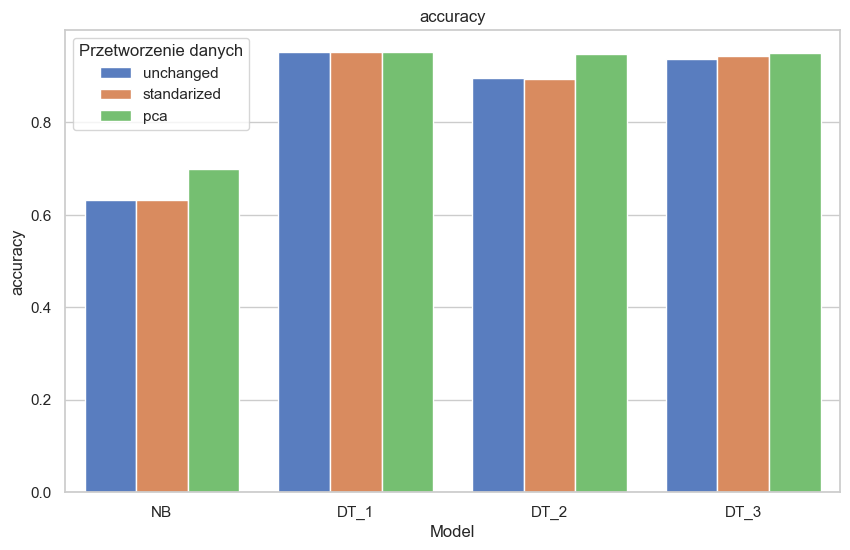

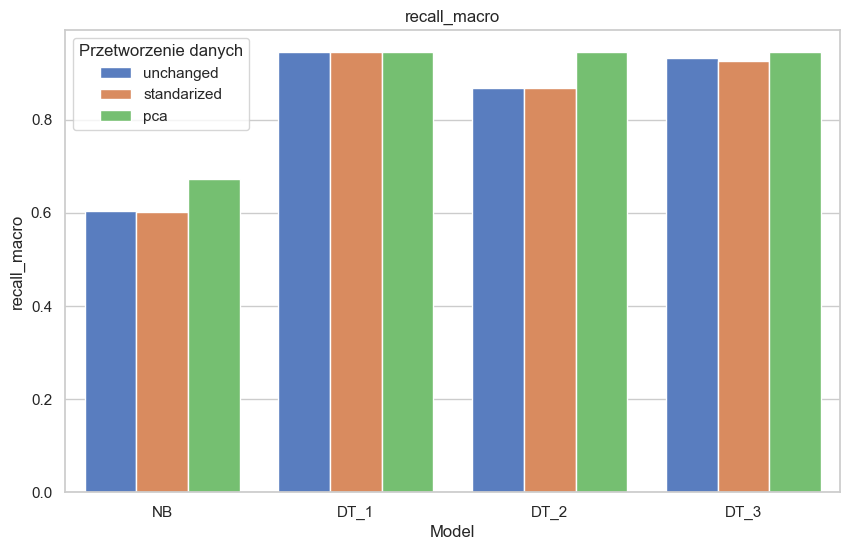

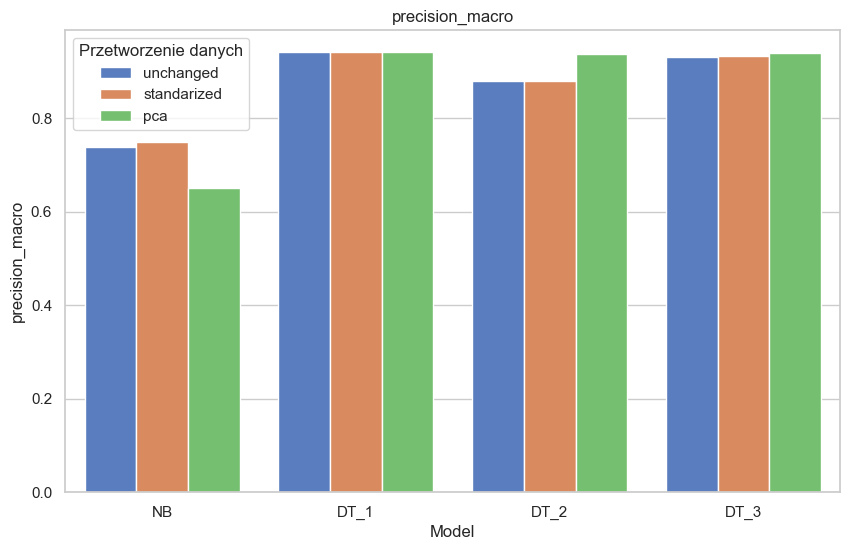

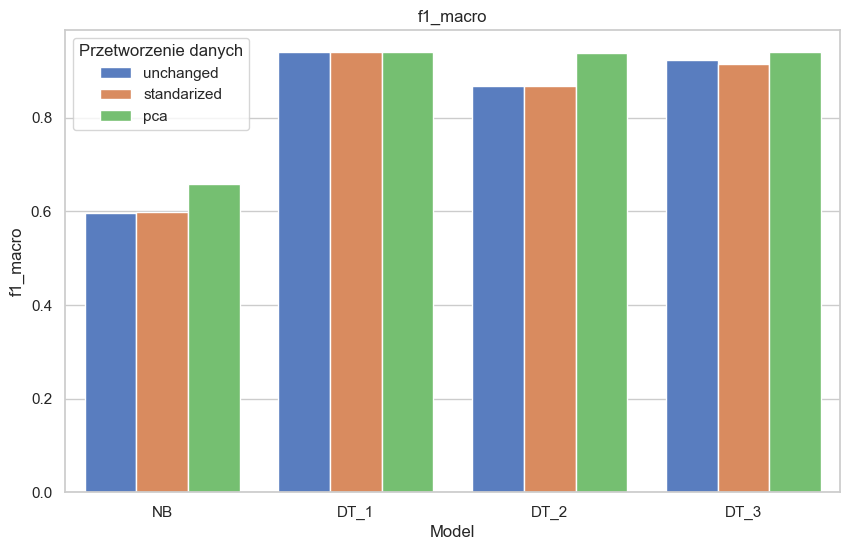

In [18]:
sns.set(style="whitegrid")

def show_chart(score):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='model', y=score, hue='data', palette='muted')
    plt.title(score)
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.legend(title='Przetworzenie danych')
    plt.show()
    

for score in scoring:
    show_chart(score)


Wykresy porównujące wyniki modeli i danych w poszczególnych metrykach.

In [23]:
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_pca, Y_data, test_size=test_size, random_state=seed)

DT_1_PCA = models[1][1]

DT_1_PCA.fit(X_train, Y_train)

predictions = DT_1_PCA.predict(X_test)
print("accuracy score: ", accuracy_score(Y_test, predictions))
print("confusion_matrix:\n", confusion_matrix(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions))

accuracy score:  0.9685
confusion_matrix:
 [[1758    0   11]
 [   0  424   29]
 [  50   36 1692]]

classification_report:
               precision    recall  f1-score   support

        high       0.97      0.99      0.98      1769
         low       0.92      0.94      0.93       453
      medium       0.98      0.95      0.96      1778

    accuracy                           0.97      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.97      0.97      0.97      4000


Jako najlepszy model uznany zostało drzewo decyzyjne trenowane danymi po przetworzeniu PCA. Miary dla klas high oraz medium mają trochę wyższe wyniki od low, co najprawdopodobniej wynika z dużo mniejszej ilości rekordów dla low w danych źródłowych. Jednak różnica jest na tyle nieznaczna, że nie wpływa na jakość całego modelu.